In [1]:
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
strict = np.loadtxt('../Data_backup/parsed/master_strict.gz',delimiter="\t") 
#SUMMER_STUDENTS_2020/mens/Coincidence_analysis/parsing/coincidences/stricter_parsing/master.gz
sdiffs = np.around(strict.T[0],1)

In [3]:
def gaussian(x, amplitude, mean, stddev):
    '''Returns the gaussian distribution with the given parameters 
        x can be single value or array'''
    return amplitude * np.exp(-((x - mean) / np.sqrt(2) / stddev)**2)

def plotPrep(arr,binnum=50):
    '''Get arr ready for standard plotting (see below where this is used)
        This function takes arr and histograms it and returns the values of each bin in the hist
        along with the x value of the middle of each bin'''
    vals, edges = np.histogram(arr,bins=binnum)
    binwidth = (edges[1]-edges[0])/2
    midbin = edges[:-1]+binwidth
    
    return vals, midbin

def gaussianFit(midbin,vals):
    '''This function will fit a gaussian to a hist of STRAW data and return the distribution of the fit
        for the same x-values input (the midbin parameter)
        It will also print out the fit values it found'''
    base = np.average(np.concatenate((vals[1:10],vals[-10:-1]))); adjvals = vals-base
    berr = np.std(np.concatenate((vals[1:10],vals[-10:-1])))/np.sqrt(len(np.concatenate((vals[1:10],vals[-10:-1]))))
    popt, pcov = optimize.curve_fit(gaussian, midbin, adjvals)
    gausvals = gaussian(midbin,*popt)+base
    argerr = np.sqrt(np.diag(pcov))/np.sqrt(sum(vals))
    print("Base:",base,"±",berr,"\nAmplitude:", popt[0],"±",argerr[0], "\nMean:", popt[1],"±",argerr[1],"\nStd. Dev:", popt[2],"±",argerr[2])
    return gausvals
def gaussianParams(midbin,vals):
    '''Returns only the parameters of the gaussian fit and not the distribution itself, along with errors for each
        parameter'''
    base = np.average(np.concatenate((vals[1:10],vals[-10:-1]))); adjvals = vals-base
    berr = np.std(np.concatenate((vals[1:10],vals[-10:-1])))/np.sqrt(len(np.concatenate((vals[1:10],vals[-10:-1]))))
    popt, pcov = optimize.curve_fit(gaussian, midbin, adjvals)
    argerr = np.sqrt(np.diag(pcov))/np.sqrt(sum(vals))
   
    print("Base %.4f ± %.4f\nAmplitude: %.4f ± %.4f\nMean: %.4f ± %.4f\nStd. Dev: %.4f ± %.4f" % (base,berr,popt[0],argerr[0],popt[1],argerr[1],popt[2],argerr[2]))
    return np.array([[base,berr],[popt[0],argerr[0]],[popt[1],argerr[1]],[popt[2],argerr[2]]])

<IPython.core.display.Javascript object>


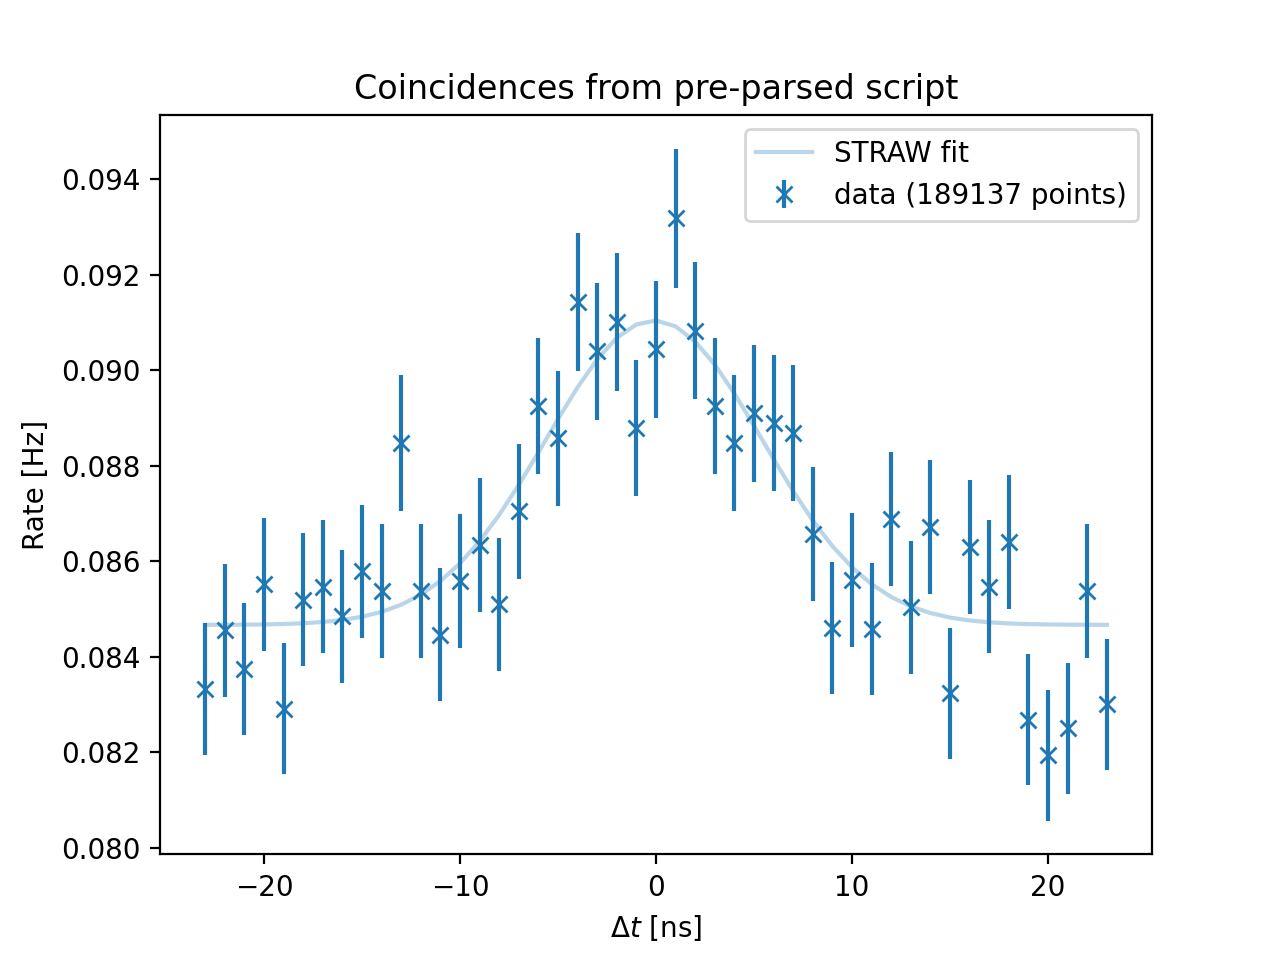

Base: 0.08466994801335087 ± 0.00033560887478141955 
Amplitude: 0.006370025378740314 ± 0.000263604933941326 
Mean: -0.10166314101377272 ± 0.2644697503462054 
Std. Dev: 5.534249151465423 ± 0.26446990464893544


In [6]:
#plot the sdiffs and a fit of them
num_s = 4.387494e7/1000
dtau = 1
bi = np.arange(-24.5,25,dtau)
sdiffplot = plotPrep(sdiffs,binnum=bi)
plt.close()
plt.figure()
plt.subplot(1,1,1)
plt.errorbar(sdiffplot[1][1:-1],sdiffplot[0][1:-1]/num_s,yerr=np.sqrt(sdiffplot[0][1:-1])/num_s,fmt='x',label="data ("+str(len(sdiffs))+" points)",color="C0")
plt.plot(sdiffplot[1][1:-1],gaussianFit(sdiffplot[1][1:-1],sdiffplot[0][1:-1]/num_s),label=r"STRAW fit",color='C0',alpha=0.3)
plt.legend(loc=0)
plt.xlabel(r'$\Delta t$ [ns]')
plt.ylabel('Rate [Hz]')
plt.title("Coincidences from pre-parsed script")
plt.show()

In [6]:
#find salinity, from ANTARES paper
params = gaussianParams(sdiffplot[1][1:-1],sdiffplot[0][1:-1]/num_s)
a = params[1][0]; sig = params[3][0]; #dtau = 0.4
R= a*sig*np.sqrt(2*np.pi)/dtau; dR = R*np.sqrt((params[1][1]/params[1][0])**2+(params[3][1]/params[3][0])**2)
#check with simulation?
print("R = %.4f ± %.4f Hz\n" % (R, dR))
Vc = 4.5e-6 ; dVc = 0
Bq = R/Vc ; dBq = Bq*np.sqrt((dR/R)**2+(dVc/Vc)**2)
print("Bq = %.4f ± %.4f s-1m-3\n" % (Bq, dBq))
rk=0.011; ri = 1.17e-4; rho = 1.013*(100**3);t12=1.25e9*365*24*3600;A=39.96
val = (rk*ri*rho*(np.log(2)/t12)*(6.02e23/A))
rs = Bq/val; drs = rs*np.sqrt((dBq/Bq)**2)
print("rs = %.5f ± %.5f\n" %(rs, drs))
print("Actaul rs=0.0348")

Base 0.0847 ± 0.0003
Amplitude: 0.0064 ± 0.0003
Mean: -0.1017 ± 0.2645
Std. Dev: 5.5342 ± 0.2645
R = 0.0884 ± 0.0056 Hz

Bq = 19637.0972 ± 1241.3622 s-1m-3

rs = 0.05686 ± 0.00359

Actaul rs=0.0348


In [8]:
def salinity(a,sig,dtau,Vc): #Vc in m3 
    R = a*sig*np.sqrt(2*np.pi)/dtau
    Bq = R/Vc
    
    rk=0.011; ri = 1.17e-4; rho = 1.013*(100**3);t12=1.25e9*365*24*3600;A=39.96
    val = (rk*ri*rho*(np.log(2)/t12)*(6.02e23/A))
    rs = Bq/val
    
    print("R = %.4f Hz"% R)
    print("Bq = %.4f s-1m-3" % Bq)
    print("Bq for Cascadia Basin: 12 133 s-1m-3\n")
    print("rs = %.5f"  % rs)
    print("rs for Cascadia Basin: 0.0348")

In [9]:
#antares cross check
print("ANTARES")
salinity(0.63,3.73,0.4,1100/(100**3))

ANTARES
R = 14.7258 Hz
Bq = 13387.1041 s-1m-3
Bq for Cascadia Basin: 12 133 s-1m-3

rs = 0.03876
rs for Cascadia Basin: 0.0348


# New July Data

In [12]:
jul = np.loadtxt('../Data_backup/parsed/newJuly/coinc_all.txt',delimiter="\t")
julyMs = np.loadtxt('../Data_backup/parsed/newJuly/ms_all.txt',delimiter="\t")
#SUMMER_STUDENTS/mens/Coincidence_analysis/parsing/coincidences/newJulyData/
july = np.around(jul.T[0],1)
fullNew = np.concatenate((sdiffs,july))

<IPython.core.display.Javascript object>


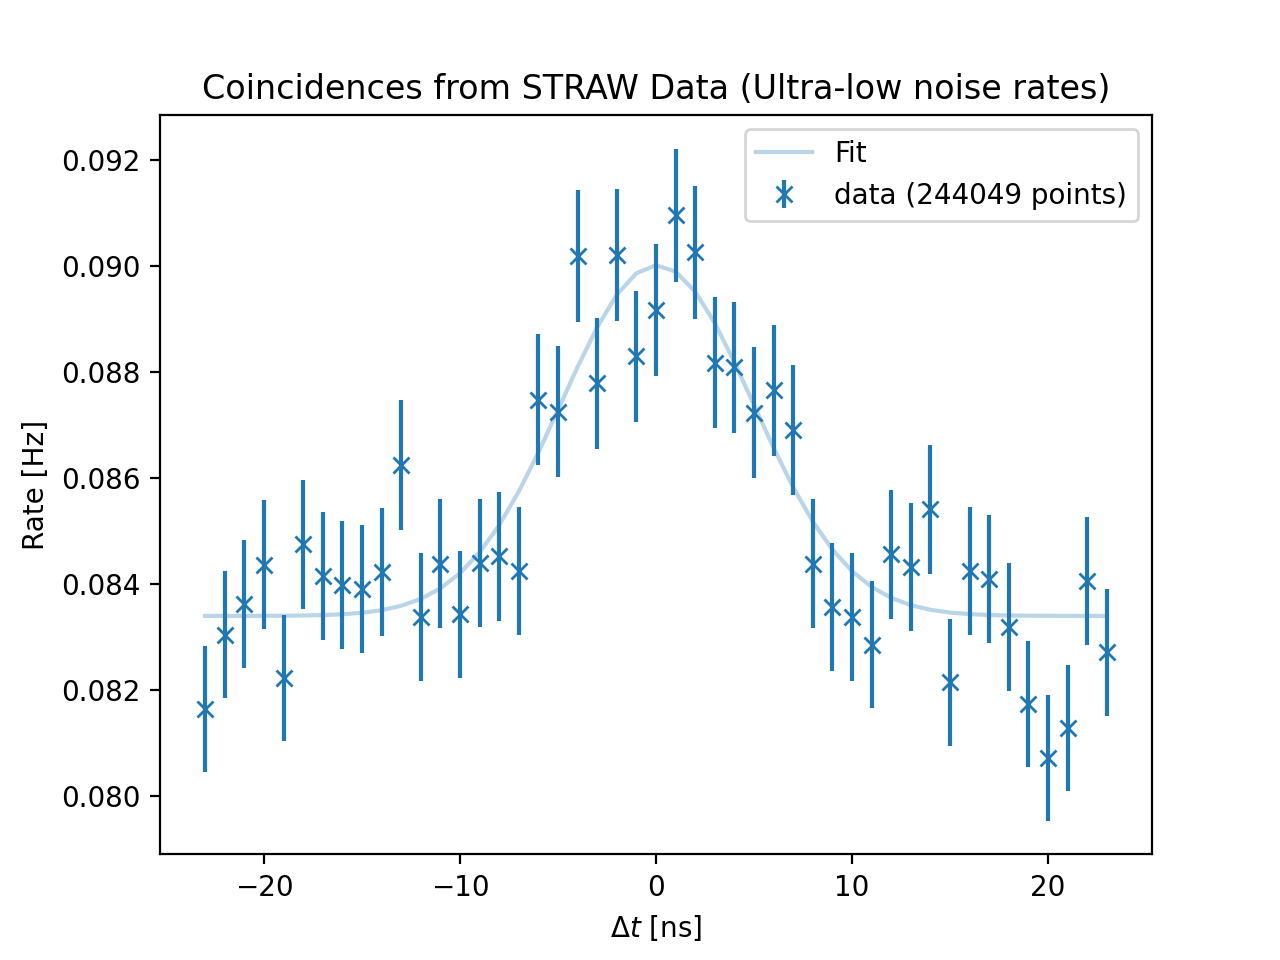

Base: 0.08339523341660511 ± 0.0002932248113914904 
Amplitude: 0.006618654210427593 ± 0.0002450850513045688 
Mean: 0.056659772598112855 ± 0.20950335373340903 
Std. Dev: 4.899726757403616 ± 0.20950331873603842


In [13]:
total_t= (np.sum(julyMs.T[1])/1000)+num_s #put julyMs here
#plot new July data plus old data from before for full data analysis
dtau=1
bi = np.arange(-24.5,25,dtau)
jplot = plotPrep(fullNew, binnum=bi)
plt.close()
plt.figure()
plt.errorbar(jplot[1][1:-1],jplot[0][1:-1]/total_t,yerr=np.sqrt(jplot[0][1:-1])/total_t,fmt='x',label="data ("+str(len(fullNew))+" points)",color="C0")
plt.plot(jplot[1][1:-1],gaussianFit(jplot[1][1:-1],jplot[0][1:-1]/total_t),label=r"Fit",color='C0',alpha=0.3)
plt.legend(loc=0)
plt.xlabel(r'$\Delta t$ [ns]')
plt.ylabel('Rate [Hz]') #change back to rate later
plt.title("Coincidences from STRAW Data (Ultra-low noise rates)")
plt.show()

In [14]:
#find salinity including newest data
gaussianParams(jplot[1][1:-1],jplot[0][1:-1]/total_t)
print("\n")
salinity(0.0066,4.8997,1,6.471e-6) #best veff is 6.745e-6 12% lower
#Bq err
damp = (0.00025/0.006618); ddev = (0.2095/4.9); dveff = 0.123/6.471
err = np.sqrt(damp**2+ddev**2+dveff**2)
print("\nPercent error: %.4f (Multipy by 100 for %%)" %err)

Base 0.0834 ± 0.0003
Amplitude: 0.0066 ± 0.0002
Mean: 0.0567 ± 0.2095
Std. Dev: 4.8997 ± 0.2095


R = 0.0811 Hz
Bq = 12526.5639 s-1m-3
Bq for Cascadia Basin: 12 133 s-1m-3

rs = 0.03627
rs for Cascadia Basin: 0.0348

Percent error: 0.0601 (Multipy by 100 for %)
